### 데이터 불러오기

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # input data normalization   
    #transform.Normalize((mean_1, mean_2, mean_3), (std_1, std_2, std_3)): 각 채널별로 mean값, std값을 할당하여 normalize

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 데이터 일부 확인

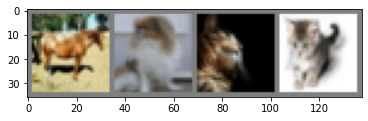

horse dog   cat   cat  


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

## 모델 정의
이후부터 과제 진행하시면 됩니다! 위는 수정 XX

'#####으로 표시된 부분에 작성하세요!

In [4]:
import torch.nn as nn

In [7]:
# conv.layer, relu, pooling layer, fc layer를 모두 1층 이상 사용하는 모델 Net()을 만들어주세요

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=6,kernel_size=5),
            nn.BatchNorm2d(6),  # Batch Normalization
            nn.ReLU(),
            #nn.Dropout2d(0.2),  # dropout
            nn.MaxPool2d(kernel_size=2,stride=2),
            nn.Conv2d(in_channels=6,out_channels=16,kernel_size=5),
            nn.BatchNorm2d(16), # Batch Normalization
            nn.ReLU(),
            #nn.Dropout2d(0.2),  # dropout
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.fc_layer = nn.Sequential(                                          
            nn.Linear(16*5*5,120),
            nn.BatchNorm1d(120),    # Batch Normalization
            nn.ReLU(),
            nn.Linear(120,84),
            nn.BatchNorm1d(84),     # Batch Normalization
            nn.ReLU(),
            nn.Linear(84,10)
        )
        # Kaiming He initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)  
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.fill_(0)    

    def forward(self, x):
        x = self.layer(x)
        x = x.view(x.size(0),-1)

        x = self.fc_layer(x)

        return x


net = Net()

## 손실함수, optimizer 정의
필요한 모듈을 import하고 손실함수는 CrossEntropyLoss, optimizer는 SGD를 사용해주세요.

optimizer의 하이퍼파라미터는 lr=0.001, momentum=0.9로 통일합니다.

작성한 모델이 무거워 실행 시간이 오래 걸린다면 GPU를 활용하세요.

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 모델 구조 확인
필요한 모듈을 import하여 모델의 구조를 확인하세요.

In [9]:
# input 사이즈 확인
print(trainset.__getitem__(0)[0].size(), trainset.__len__())
print(testset.__getitem__(0)[0].size(), testset.__len__())

print(len(trainset),len(testset))

torch.Size([3, 32, 32]) 50000
torch.Size([3, 32, 32]) 10000
50000 10000


In [10]:
!pip install torchsummary

In [11]:
from torchsummary import summary
summary(net, (3,32,32), batch_size=4)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [4, 6, 28, 28]             456
       BatchNorm2d-2             [4, 6, 28, 28]              12
              ReLU-3             [4, 6, 28, 28]               0
         Dropout2d-4             [4, 6, 28, 28]               0
         MaxPool2d-5             [4, 6, 14, 14]               0
            Conv2d-6            [4, 16, 10, 10]           2,416
       BatchNorm2d-7            [4, 16, 10, 10]              32
              ReLU-8            [4, 16, 10, 10]               0
         Dropout2d-9            [4, 16, 10, 10]               0
        MaxPool2d-10              [4, 16, 5, 5]               0
           Linear-11                   [4, 120]          48,120
      BatchNorm1d-12                   [4, 120]             240
             ReLU-13                   [4, 120]               0
           Linear-14                   

## Train

In [12]:
# 모델을 학습

for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.231
[1,  4000] loss: 2.107
[1,  6000] loss: 2.049
[1,  8000] loss: 2.018
[1, 10000] loss: 1.999
[1, 12000] loss: 1.997
[2,  2000] loss: 1.960
[2,  4000] loss: 1.940
[2,  6000] loss: 1.946
[2,  8000] loss: 1.931
[2, 10000] loss: 1.916
[2, 12000] loss: 1.904
Finished Training


## Test

In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [14]:
## 아래 코드 그대로 실행

correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 31 %


## 클래스별 accuracy 비교

In [15]:
## 아래 코드 그대로 실행

# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 38.8 %
Accuracy for class: car   is 50.4 %
Accuracy for class: bird  is 10.3 %
Accuracy for class: cat   is 17.9 %
Accuracy for class: deer  is 6.5 %
Accuracy for class: dog   is 25.3 %
Accuracy for class: frog  is 50.8 %
Accuracy for class: horse is 37.5 %
Accuracy for class: ship  is 46.4 %
Accuracy for class: truck is 27.7 %
